<h2> appendix

In [439]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances,accuracy_score
from sklearn.cluster import AgglomerativeClustering,KMeans
from scipy.spatial.distance import squareform, pdist
from scipy.stats import multivariate_normal as P
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_classification , make_circles,make_s_curve
import mpl_toolkits.mplot3d 
from scipy.spatial import distance
from scipy.spatial.distance import squareform, pdist
from sklearn.neighbors import NearestNeighbors


In [440]:
def evaluate_accuracy(predictions,labels):
    accuracy = accuracy_score(labels, predictions)
    return accuracy*100

In [441]:
def get_random_covariance(d):
    """
    Function to generate a random, valid covariance matrix of size d x d
    """
    sigma = np.random.rand(d, d) - 0.5
    sigma = np.dot(sigma, sigma.T)  # make the matrix symmetric
    return sigma


def get_random_gaussian_dist(d, distance=5):
    """
     generate a random Gaussian distribution with mean mu and covariance matrix sigma
    The distance parameter specifies the distance of the mean from the origin
    """
    sigma = get_random_covariance(d)  # generate a random covariance matrix
    mu = np.array(np.random.rand(d)) * distance  # generate a random mean
    return mu, sigma


def generate_normal_datapoint(guaussian_dist):
    """
     generate a single datapoint from a Gaussian distribution with mean and covariance matrix guaussian_dist
    """
    mean = guaussian_dist[0]
    cov = guaussian_dist[1]
    dp = np.random.multivariate_normal(mean, cov, check_valid='warn', tol=1e-8)
    return dp


def generate_gaussian_cluster(guaussian_dist, k,d = 2, dataset=None):
    """
    Function to generate a cluster of k datapoints from the Gaussian distribution guaussian_dist
    The dataset parameter can be used to append the generated cluster to an existing dataset
    gauss_dist is a tuple of the form (mean, covariance matrix)
    """
    cluster = np.empty((0, d))  # initialize an empty array to store the datapoints
    for i in range(k):
        p = generate_normal_datapoint(guaussian_dist)  # generate a single datapoint
        cluster = np.append(cluster, [p], axis=0)  # add the datapoint to the cluster
    if dataset:
        dataset = np.append(dataset, cluster)  # append the cluster to an existing dataset, if provided
    return cluster

def generate_clusters(n,k,d):
    colors =[]
    clusters = []
    # for k clusters:
    for i in range (k):
        cluster = generate_gaussian_cluster(get_random_gaussian_dist(d),n[i],d = d)
        clusters.append([cluster])
        #colors.append(np.random.uniform(0,1)/4+3*k/4)
    return clusters

def plot_loss(loss):
    plt.figure()
    plt.plot(range(len(loss)),loss)
    plt.title("loss vs. iteration no.")
    plt.xlabel("iteration")
    plt.ylabel("|loss|")
    plt.show()

def get_rand_centroids(K,d):
    centroids = np.random.rand(K, d)
    return centroids

In [442]:
def get_gaussian_line_shape_distribution(p1,p2):
    v = p2 - p1
    v_norm = np.linalg.norm(v)
    u = v/v_norm

    sigma = v_norm * np.outer(u,u)

    epsilon = 0.005 * np.identity(sigma.shape[0])
    sigma +=epsilon

    mu = p1 + (p2 - p1)/2

    return mu, sigma



<h3> MLE


In [443]:
def E_step(data, phi, mu, sigma):
    """
       Perform E-step on GMM model
       Each datapoint will find its corresponding best cluster center
       ---
       Inputs:
            data: (n, d) array, where n is # of data points and d is # of dimensions
            phi: (k, d) array, where k is # of clusters
            mu: (k, d) array, where k is # of clusters and d is # of dimensions
            sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions

       Returns:
            'w': (k,n) array indicating the cluster of each data point
                        where k is # of clusters and n is # of data points
       """
    n = len(data)
    k = len(phi)
    w = np.zeros((k, n))
    log_likelyhood = 0
    
    for i in range(n):
        norm_i = 0
        for j in range(k):
            w[j, i] = P(mu[j], sigma[j]).pdf(data[i]) * phi[j]
            norm_i += w[j, i]
        w[:, i] /= norm_i
        
        log_likelyhood -= np.log(norm_i)    # compute log-likelyhood
    return w, log_likelyhood


def M_step(data, w, phi, mu, sigma):
    """
    M-step: Update our estimate of μ, σ2 and using the new values of the latent variables z.
    Inputs:
        clusters: (n) array indicating the cluster of each data point
        data: (n, d) array, where n is # of data points and d is # of dimensions
        mu: (k, d) array, where k is # of clusters and d is # of dimensions
        sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions

    Returns:
        mu: (k, d) array, where k is # of clusters and d is # of dimensions
        sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions
    """
    sum_of_all_w = np.sum(w)
    # iterate over each gaussian, calculate μ, σ2:

    for j in range(len(mu)):
        sum_over_wj = np.sum(w[j])
        # μ <- (1/sum over wj) * weighted sum over all the data points
        mu[j] = np.sum(np.array([xi*w[j,i] for i, xi in enumerate(data)]), axis=0) / sum_over_wj
        # σ2 <- wheighted sum over all the data points in cluster((datapoint value - μ_new)**2)
        sigma[j] = np.sum(np.array([np.outer((xi - mu[j]).T, xi - mu[j]) * w[j, i] for i, xi in enumerate(data)]), axis=0)/sum_over_wj

        phi[j] = sum_over_wj/sum_of_all_w

    return phi, mu, sigma

# Input: data, model

def MLE(data,labels, initial_model,headline, case = 2, plot = True):
    d = data.shape[1]

    # 1. Initialize model parameters

    phi, mu, sigma = initial_model

    # 2. while not converged:
    converged = False
    i = 0
    iteration_log_likelihood = [0.0]



    while not converged and i<150:

        # 2.1     E-step: compute expected value of latent variable given current parameters
        w,lol = E_step(data , phi, mu, sigma)
        iteration_log_likelihood.append(lol)
        # 4.     M-step: update parameters to maximize expected likelihood
        if case == 1:
            PHI, SIGMA = phi, sigma
            _, mu, _ = M_step(data, w, phi, mu, sigma)
            phi, sigma = PHI, SIGMA
        if case == 2:
            phi, mu, sigma = M_step(data, w, phi, mu, sigma)
        

        i += 1
        converged = (abs(iteration_log_likelihood[i]-iteration_log_likelihood[i-1]) < 0.00001)

     # Calculate predictions for each data point
    n = data.shape[0]
    predictions = np.argmax(w, axis=0)
    
    scatter_plt2D(data, predictions,headline )
    
    # 5. return model
    return phi, mu, sigma,  iteration_log_likelihood,predictions


In [444]:
def initial_model(D,k,d,init_metod,phi, sigma):
    """

    :param c: # of Gaussians in model
    :param d: # of dimentions of datapoints

    :return: an arbitrary initial condition  model for MLE. containing:
             phi: amplitude of Gaussians, np array (k)
             mu: np array(k,d)
             sigma: covariance matrix of gausians, np aray (k,d,d)


    """
    sigmas = np.zeros((k, d, d)) 
    if init_metod=='rand':
        mu = np.array([np.random.multivariate_normal([0]*d, np.eye(d,d)) for i in range(k)])
    else:
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(D)
        mu = kmeans.cluster_centers_

    if phi==None and sigma==None:
        phi = np.random.rand(k)
        phi /= sum(phi)
       

        for i in range(k):
            sigma = np.random.rand(d, d)
            sigma = np.dot(sigma, sigma.T)
            sigmas[i] = sigma
            

    


 
    return phi, mu, sigmas

In [445]:
def plot_log_likelihood(lol):
    plt.plot(range(len(lol[2:])),lol[2:])
    plt.title("log likelyhood vs. iteration no.")
    plt.xlabel("iteration")
    plt.ylabel("|log liklyhood|")
    plt.show()

In [446]:
def get_distance_2d(cluster_1, cluster_2, distance_metric="euclidean"):
    """Gets the distance between the two given 2D clusters.

    Args:
      cluster_1: A list of 2D data points.
      cluster_2: A list of 2D data points.
      distance_metric: The distance metric to use. Can be "euclidean" or "manhattan".

    Returns:
      The distance between the two clusters.
    """
    sum=0
    for data_point1 in cluster_1:
        for data_point_2 in cluster_2:

            if distance_metric == "euclidean":
                sum=sum+(data_point1-data_point_2)**2
            elif distance_metric == "manhattan":
                sum=sum+abs(data_point1-data_point_2)
    if distance_metric == "euclidean":
        sum=math.sqrt(sum)
    return sum

In [447]:
def find_closest_clusters_2d(clusters):
    """Finds the two closest clusters in the given list of 2D clusters.

    Args:
      clusters: A list of lists, where each inner list represents a 2D cluster.
      distance_metric: The distance metric to use. Can be "euclidean" or "manhattan".

    Returns:
      A list of two lists, where the first list is the first cluster and the second
      list is the second cluster.
    """

    closest_clusters = []
    closest_distance = float("inf")

    for cluster_1 in clusters:
        for cluster_2 in clusters:
            if cluster_1 [1] == cluster_2[1] and cluster_1 [0] == cluster_2[0]:
                continue

            dist = distance.euclidean(cluster_1, cluster_2)
            if dist < closest_distance:
                closest_distance = dist
                closest_clusters = [cluster_1, cluster_2]

    return closest_clusters



<h2>AGG

In [448]:
#agg optimal cluster via sklearn
def agg_optimal_clustering_case1(D,labels, K,headline):
    # Create an instance of AgglomerativeClustering
    clustering = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage='ward')

    # Fit the model to your data
    clustering.fit(D)

    # Obtain the predicted labels
    predictions = clustering.labels_
    
    scatter_plt2D(data, predictions,headline )
    return predictions
def agg_optimal_clustering_case2(D, K):
    # Create an instance of AgglomerativeClustering
    clustering = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage='ward')

    # Fit the model to your data
    clustering.fit(D)

    # Obtain the predicted labels
    predictions = clustering.labels_
    print(predictions)

    return predictions

In [449]:
class HCAGG:
    def __init__(self, data, max_clusters, linkage,  m=2,error=1e-5):
        self.u, self.centroids, self.weights = None, None, None
        self.max_clusters = max_clusters
        self.data = data
        self.m = m
        self.linkage= linkage
        self.error = error

         # Map the names of the distance functions to their implementations
        self.distance_functions = {
            'single': self.dmin,
            'complete': self.dmax,
            'average': self.davg,
            'centroid': self.dmean
        }
       
    # Implementing Euclidean distance
    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    # Single-linkage clustering (Minimum distance)
    def dmin(self,cluster1, cluster2):
        return min(self.euclidean_distance(x1, x2) for x1 in cluster1 for x2 in cluster2)

    # Complete-linkage clustering (Maximum distance)
    def dmax(self , cluster1, cluster2):
        return max(self.euclidean_distance(x1, x2) for x1 in cluster1 for x2 in cluster2)

    # Average-linkage clustering (Average distance)
    def davg(cluster1, cluster2):
        return np.mean([self.euclidean_distance(x1, x2) for x1 in cluster1 for x2 in cluster2])

    # Centroid-linkage clustering (Mean distance)
    def dmean(self ,cluster1, cluster2):
        return self.euclidean_distance(np.mean(cluster1, axis=0), np.mean(cluster2, axis=0))



    # The agglomerative hierarchical clustering algorithm
    def agglomerative_clustering(self, data, num_clusters, linkage):
        # Each data point is a separate cluster at the start
        clusters = [[point] for point in data]

        # Continue until we have the desired number of clusters
        while len(clusters) > num_clusters:
            # Find the two closest clusters
            min_distance = float('inf')
            closest_clusters = None

            for i, cluster1 in enumerate(clusters):
                for j, cluster2 in enumerate(clusters):
                        distance = self.distance_functions[linkage](cluster1, cluster2)
                        if distance < min_distance:
                            min_distance = distance
                            closest_clusters = (i, j)

            # Merge the two closest clusters
            clusters[closest_clusters[0]] += clusters[closest_clusters[1]]
            del clusters[closest_clusters[1]]

        return clusters

In [450]:
def compare_clustering(D, k,headline):
    

    # Agglomerative clustering (single linkage)
    model = AgglomerativeClustering(n_clusters=k, linkage='single')
    predictions = model.fit_predict(D)
    scatter_plt2D(D, predictions,headline+" single linkage" )
    

    # Agglomerative clustering (complete linkage)
    model = AgglomerativeClustering(n_clusters=k, linkage='complete')
    predictions = model.fit_predict(D)
    scatter_plt2D(D, predictions,headline +" complete linkage")

    # Agglomerative clustering (average linkage)
    model = AgglomerativeClustering(n_clusters=k, linkage='average')
    predictions = model.fit_predict(D)
    scatter_plt2D(D, predictions,headline +" average linkage")
    
    # Agglomerative clustering (ward linkage)
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    predictions = model.fit_predict(D)
    scatter_plt2D(D, predictions,headline +" ward linkage")

<h2>UFOC

In [451]:
def exponential_kernel(x, y, gamma):
    return np.exp(-gamma * np.linalg.norm(x - y)**2)

def kmeans_with_exponential_kernel(data, k,cluster_centers, max_iterations=100, gamma=2.0, plot = False):
    """
    K-Means with exponential kernel
    :param data:            (N, d) nd_array of data points
    :param k:               number of clusters
    :param max_iterations:  maximum number of iterations
    :param gamma:           the exponential decay
    :return:                centroids -
                            labels -
                            loss convergence -
    """
    n_samples, n_features = data.shape

    # Initialize cluster centers randomly
    losses = []

    for iter in range(max_iterations):
        # Assign data points to the nearest cluster center
        u = np.array([np.array([exponential_kernel(x, center, gamma) for center in cluster_centers]) for x in data])
        u = u/ np.sum(u, axis=1)[:, None]

        labels = [np.argmax([exponential_kernel(x, center, gamma) for center in cluster_centers]) for x in data]
        new_cluster_centers = np.zeros((k, n_features))

        # Update cluster centers based on the mean of the data points assigned to each cluster


        # clusters.shape -> (k, n_features)
        new_cluster_centers = np.dot(u.T, data) / np.sum(u, axis=0)[:, None]


        # plot the current iteration

        if plot and (iter < 3 or not iter % 10):
            plot_clusters([data[np.array(labels) == i] for i in range(k)], title=f'iteration {iter}')
            for c in new_cluster_centers:
                plt.scatter(c[0],c[1],marker='x',s=100)

        # Check for convergence
        if np.allclose(cluster_centers, new_cluster_centers):
            break

        cluster_centers = new_cluster_centers
        loss = np.sum([-exponential_kernel(x, cluster_centers[labels[i]], gamma) for i, x in enumerate(data)])
        losses.append(loss)

    return cluster_centers, u, losses

In [480]:
def fcm(data, K, initial_centroids, max_iters = 50, fuzziness = 2, tol = 0.001, plot = False):
    """
    Classical fuzzy c-means clustering algorithm

    :param data:                ndarray of shape (N, d) where N is the number of data points and d is the dimension of the data
    :param K:                   int: number of clusters
    :param initial_centroids:   ndarray of shape (K, d) containing the initial cluster centers
    :param max_iters:           int: maximum number of iterations
    :param fuzziness:           float: fuzziness parameter
    :param tol:                 float: tolerance for convergence
    :return:                    centroids: ndarray of shape (K, d) containing the final cluster centers
                                membership: ndarray of shape (N, K) containing the membership matrix

    """
    # Randomly initialize cluster centers
    centroids = initial_centroids
    i=0
    converged = False
    iteration_loss = []
    while (not converged) and i < max_iters:
        # Calculate the membership matrix
        distances = np.linalg.norm(data[:, None] - centroids, axis=2)
        membership = 1 / (distances ** (2 / (fuzziness - 1)))
        membership = membership / np.sum(membership, axis=1)[:, None]

        # Update cluster centers
        m = membership ** fuzziness
        centroids = np.dot(m.T, data) / np.sum(m, axis=0)[:, None]

        clusters = [data[np.argmax(membership,axis=1)==i] for i in range(K)]

        if plot and (i<3 or not i%10) :
            plot_clusters(clusters, title=f'iteration number {i}')
            plot_centroids(centroids)

        loss = np.sum((distances**2) * m)
        iteration_loss.append(loss)

        if i >20:
            converged = (abs(loss-iteration_loss[i-1]) < tol)
        i+=1
    plot_clusters(clusters, title=f'iteration number {i}')
    plot_centroids(centroids)

    return centroids, membership, iteration_loss

In [453]:
def WUOFC(data, K_max, cluster_validity_criteria, max_iters = 50, fuzziness = 2, tol = 0.001):
    """

    :param data:                        np.array of shape (N,d)
    :param K_max:                       int: maximal feasible number of clusters
    :param cluster_validity_criteria:   fun(list clusters) -> int :function that calculates the cluster validity criteria
    :param max_iters:                   int: maximal number of iterations
    :param fuzziness:                   int: FCM fuzziness parameter
    :param tol:                         int: tolerance parameter
    :return:
    """

    #  Initialize the cluster center c_0
    centroids = [np.mean(data, axis=0)]
    k = 1
    C =[]
    V = []
    while k < K_max:
        # Calculate the membership matrix

        #call FCM with K clusters and the current cluster centers c_1, ..., c_K.
        centroids, membership, loss = fcm(data,k,centroids)

        #print centroids

        # use the centroids μcx as the new cluster centers c_1, ..., c_K fo K-means with exponential kernel algorithm.
        centroids, membership, loss = kmeans_with_exponential_kernel(data, k,centroids, max_iterations=100, gamma=2.0)

        #add centroids to C
        C.append(centroids)

        # calculate the cluster validity criteria V for the partition.
        V.append(cluster_validity_criteria(data, centroids, membership))
        print(f'K = {k} : V = {V[-1]}')

        clusters = [data[np.argmax(membership,axis=1)==i] for i in range(k)]
        plot_clusters(clusters, title=f'K = {k}')
        # add a new centroid, c_K+1 equally distant from all the other centroids, to the set of cluster centers. set K←K+1.
        k += 1
        membership = np.append(membership, np.zeros((membership.shape[0], 1)), axis=1)
        membership[:, -1] = 0.2

        # Calculate the membership matrix

        membership = membership / np.sum(membership, axis=1)[:, None]

        # Update cluster centers
        m = membership ** fuzziness
        centroids = np.dot(m.T, data) / np.sum(m, axis=0)[:, None]



    V_opt = np.argmin(np.array(V))
    C_opt = C[V_opt]
    return V_opt, C_opt

trace criteria

In [454]:
def trace_criterion(data, centroids, membership):
    # calculate the covariance matrix for each cluster
    membership = np.array(membership)
    K = membership.shape[1]

    clusters = [data[np.argmax(membership,axis=1)==i] for i in range(K)]

    V = 0
    for k in range(K):
        S_i = np.cov(clusters[k].T)
        V += np.trace(S_i)*(clusters[k].shape[0])
    return V*K


determinanta criteria

In [484]:
def determinant_criterion(data, centroids, membership):
    # calculate the covariance matrix for each cluster
    membership = np.array(membership)
    K = membership.shape[1]

    clusters = [data[np.argmax(membership,axis=1)==i] for i in range(K)]

    V=0
    for c in clusters:
        S_i = np.cov(c.T)
        V += np.linalg.det(S_i) * (1/c.shape[0])
    return V * K
    #############

the Invariant criterion

In [456]:
def invariant_criterion(data, centroids, membership):
    # calculate the covariance matrix for each cluster
    if centroids.shape[0] == 1:
        return np.inf

    #centroids = centroids.reshape(1,-1)
    membership = np.array(membership)
    K = membership.shape[1]

    clusters = [data[np.argmax(membership,axis=1)==i] for i in range(K)]

    V=0
    #print datapoint shape

    S_w = np.sum([np.cov(c.T) for c in clusters],axis=0)
    # cov between centers
    S_B = np.cov(centroids.T)
    # s_w^-1 * S_B
    S = np.linalg.inv(S_w) @ S_B

    # V = np.sum(np.linalg.eig(S))

    V = np.trace((np.linalg.inv(S_w)@ S_B))

    return V * K

In [483]:
def comper_criteria(data, k,criteria,headline):
    #compute the trace criterion
    V,C = WUOFC(data, 6, trace_criterion)
    plot_clusters([data],title=headline+ f' \n v = {V+1}')
    plot_centroids(C)

    

<h2>PLOT

In [457]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, labels):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    scatter=ax.scatter(x, y, s=40, c=labels, edgecolor='k')
    ax.set_aspect(1.)
    
    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    bins = np.arange(-lim, lim + binwidth, binwidth)

    unique_labels = np.unique(labels)
    array_length = len(unique_labels)
    x1 = [[] if i == 0 else [] for i in range(array_length)]
    y1 = [[] if i == 0 else [] for i in range(array_length)]
    for i in range(len(labels)):
        for l in range(len(unique_labels)):
            if unique_labels[l] == labels[i]:
                x1[l].append(x[i])
                y1[l].append(y[i])
    legend_handles = []
    for label in range(len(unique_labels)):
        legend_handles.append(scatter.legend_elements()[0][label])
    ax.legend(legend_handles, unique_labels, title='Labels')

    # Plot KDE curves
    # Plot histograms
    for i in range(len(unique_labels)):
        ax_histx.hist(x1[i], bins=bins, color=scatter.cmap(scatter.norm(unique_labels[i])),edgecolor='k')
        ax_histy.hist(y1[i], bins=bins, orientation='horizontal', color=scatter.cmap(scatter.norm(unique_labels[i])),edgecolor='k')

        # Plot KDE curves
       # sns.kdeplot(x1[i], ax=ax_histx, color=scatter.cmap(scatter.norm(unique_labels[i])))
      #  sns.kdeplot(y1[i], ax=ax_histy, color=scatter.cmap(scatter.norm(unique_labels[i])))

        # Compute mean and variance
        x_mean = np.mean(x1[i])
        x_var = np.var(x1[i])
        y_mean = np.mean(y1[i])
        y_var = np.var(y1[i])

    # Annotate mean and variance
    ax_histx.text(x_mean, -2, f"Mean: {x_mean:.2f}\nVar: {x_var:.2f}", ha='center', va='bottom', color='red',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    ax_histy.text(-1, y_mean, f"Mean: {y_mean:.2f}\nVar: {y_var:.2f}", ha='left', va='center', color='red',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

    #ax_histx.hist(x, bins=bins)
    #ax_histy.hist(y, bins=bins, orientation='horizontal')

    # Set labels for components
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Set labels for histograms
    ax_histx.set_ylabel('Probability Density')
    ax_histy.set_xlabel('Probability Density')
    

In [458]:
def scatter_plt2D(data, pred,headline):
    # Start with a square Figure.
    fig = plt.figure(figsize=(6, 6))
    # Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
    # the size of the marginal axes and the main axes in both directions.
    # Also adjust the subplot parameters for a square plot.
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    # Draw the scatter plot and marginals.
    scatter_hist(data[:,0], data[:,1], ax, ax_histx, ax_histy, pred)
    
    fig.suptitle(headline)
    plt.show()


In [478]:
def plot_clusters(clusters, d = 2,title = None):

    """
    Function to plot the clusters
    input: clusters - a list of clusters, where each cluster is a numpy array of datapoints
           d - the dimension of the data
    output: a plot of the clusters, where each cluster is a different color, and the datapoints are transparent to show overlapping clusters

    """
    plt.figure()
    if d == 2:
        for c in clusters:
            plt.scatter(c[:,0], c[:, 1], alpha=0.5,edgecolor='k')
    else:
        for c in clusters:
            ax = plt.axes(projection='3d')
            ax.scatter3D(c[:,0], c[:, 1], c[:, 2], alpha=0.5,edgecolor='k')
    if title:
        plt.title(title)


def plot_centroids(centroids, d = 2,title = None):
    """
    Function to plot the centroids
    input: centroids - a numpy array of centroids
           d - the dimension of the data
    output: a plot of the centroids, where each centroid is a different color

    """
    if d == 2:
        for c in centroids:
            plt.scatter(c[0],c[1],marker='x',s=100,edgecolor='k')
    else:
        for c in centroids:
            ax.scatter3D(c[0], c[1], c[2], marker='x', s=100,edgecolor='k')


<h2>2D gaussian data with two center

In [460]:
k=2         # number of clusters
d=2         # number of dimentions
N = 500    # number of datapoints

phi = [0.7, 0.3]
sigma = [np.array([[0.6,0],[0,0.6]]),np.array([[0.8,-0.3],[-0.3,0.6]])]
mu = [np.array([1,1]),np.array([-1,-1])]
init = initial_model(data,k,d,'rand',phi,sigma)
distribution_1 = (mu[0],sigma[0])
distribution_2 = (mu[1],sigma[1])

data = np.concatenate((cluster_1,cluster_2),axis=0)

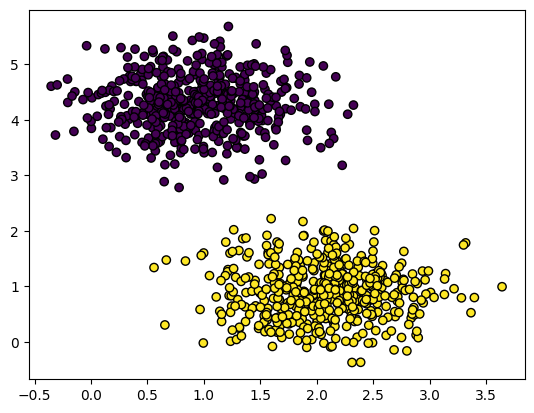

In [471]:
k=2
d=2
data, labels = make_blobs(n_samples=1000, centers=k, cluster_std=0.5, random_state=0, n_features=d)

#colors = np.random.rand(N)
plt.scatter(data[:, 0], data[:, 1], c=labels, edgecolor='k')


mle estimation using random initialization:

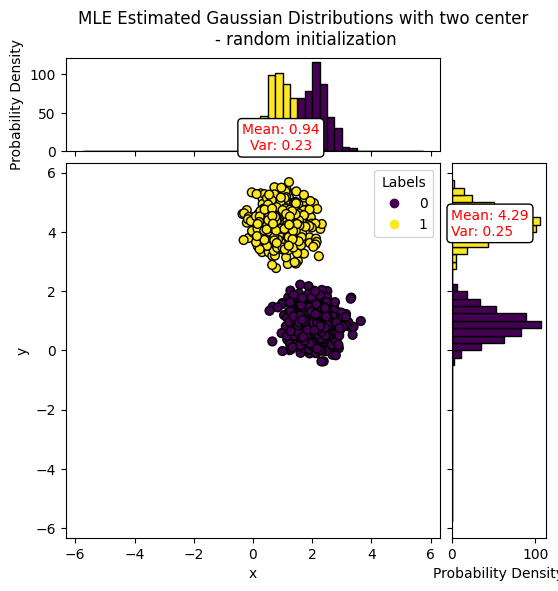

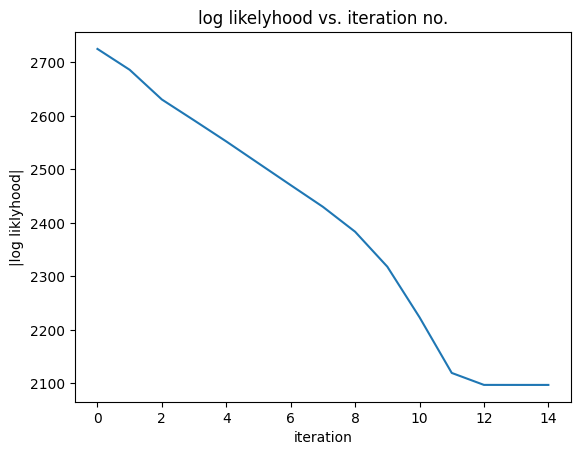

In [462]:
init = initial_model(data,k,d,'rand',phi=None,sigma=None)
phi, mu, sigma, lol ,pred= MLE(data,labels,init,'MLE Estimated Gaussian Distributions with two center \n- random initialization',case=1)
plot_log_likelihood(lol)

mle estimation using KNN initialization:

In [463]:
init = initial_model(data,k,d,'knn',phi=None,sigma=None)
phi, mu, sigma, lol ,pred= MLE(data,labels,init,'MLE Estimated Gaussian Distributions with two center \n- KNN initialization',case=1)
plot_log_likelihood(lol)

KeyboardInterrupt: 

agg clustering

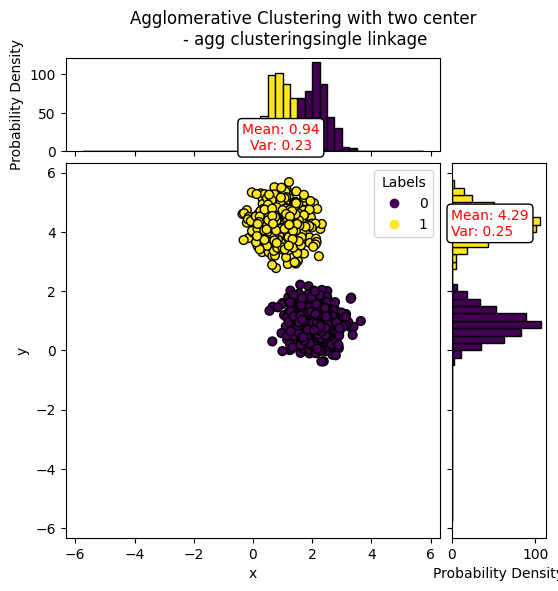

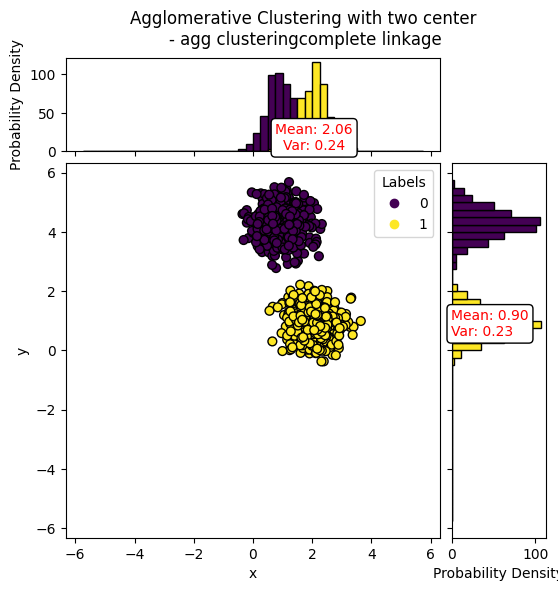

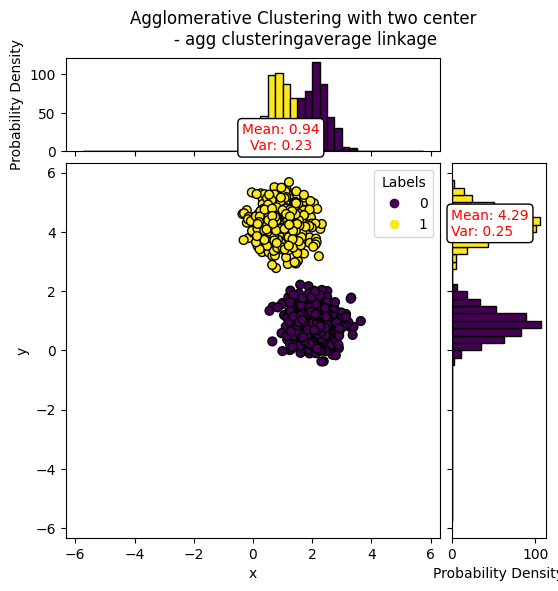

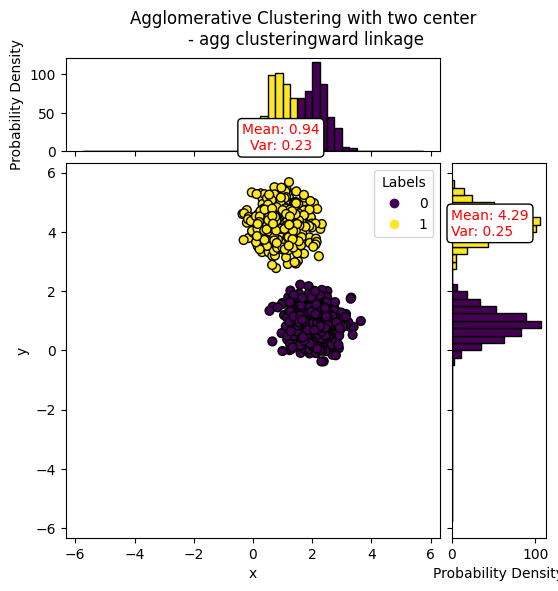

In [ ]:
#pred4 = agg_optimal_clustering_case1(data, labels, k, "Agglomerative Clustering with two center \n- agg clustering")
compare_clustering(data,k,"Agglomerative Clustering with two center \n- agg clustering")

UFOC

In [ ]:
comper_criteria(data, k,trace_criterion,"HFOC outcome for trace criteria")

In [ ]:

comper_criteria(data, k,determinant_criterion,"HFOC outcome for determination criteria")

In [482]:

comper_criteria(data, k,invariant_criterion,"HFOC outcome for invariant criteria")

TypeError: comper_criteria() takes 3 positional arguments but 4 were given

<h2>2D gaussian data with one center

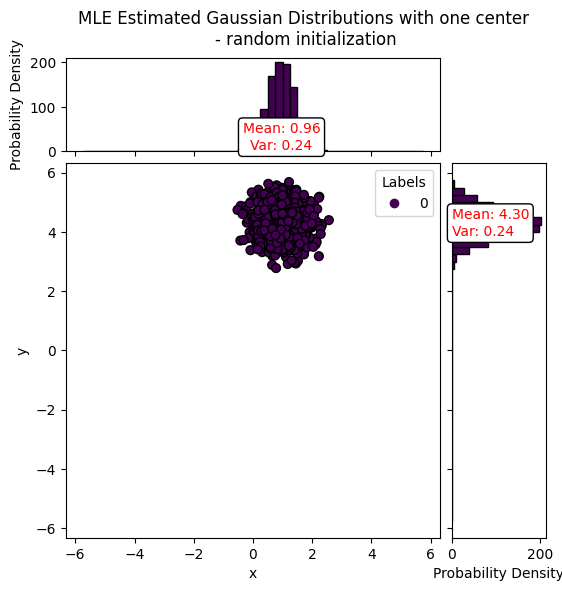

Accuracy: 100.00%


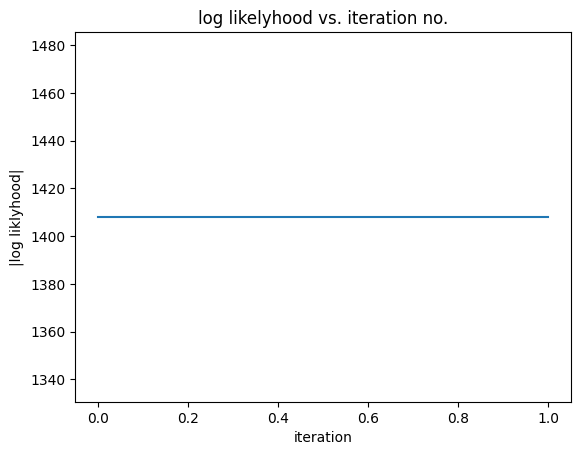

In [ ]:
k=1
d=2
data, labels = make_blobs(n_samples=1000, centers=k, cluster_std=0.5, random_state=0, n_features=d)
init1 = initial_model(data,k, d, 'rand', phi=None, sigma=None)
phi1, mu1, sigma1, lol1, pred1 = MLE(data,labels, init1,'MLE Estimated Gaussian Distributions with one center \n- random initialization', case=1)
plot_log_likelihood(lol1)


 mle estimation using KNN initialization:

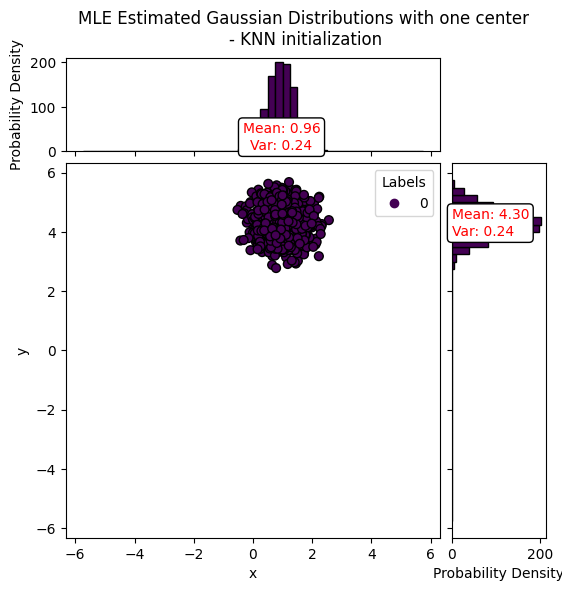

Accuracy: 100.00%


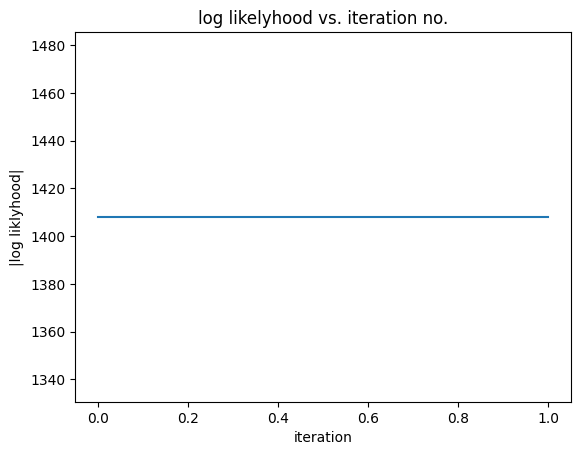

In [ ]:
init1 = initial_model(data,k, d, 'knn', phi=None, sigma=None)
phi1, mu1, sigma1, lol1, pred1 = MLE(data,labels, init1,'MLE Estimated Gaussian Distributions with one center \n- KNN initialization', case=1)
plot_log_likelihood(lol1)

agg clustering

c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


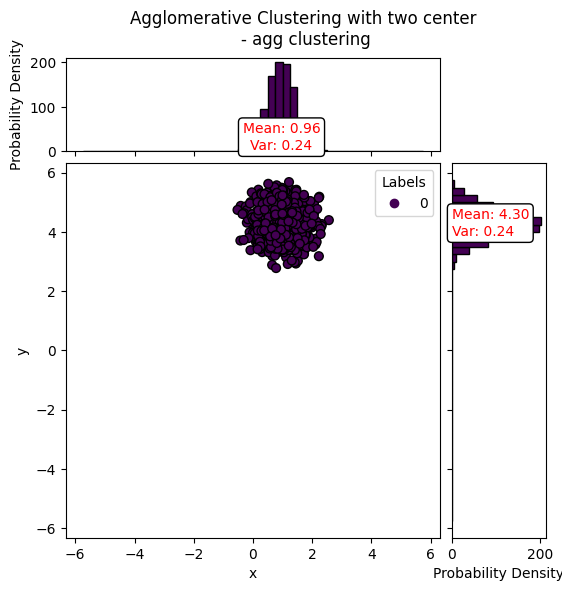

Accuracy: 100.00%


In [ ]:
#pred4 = agg_optimal_clustering_case1(data, labels, k, "Agglomerative Clustering with two center \n- agg clustering")
compare_clustering(data,k,"Agglomerative Clustering with one center \n- agg clustering")

UFOC

In [ ]:
comper_criteria(data, k,trace_criterion,"HFOC outcome for trace criteria")

In [ ]:

comper_criteria(data, k,determinant_criterion,"HFOC outcome for determination criteria")

In [ ]:

comper_criteria(data, k,invariant_criterion,"HFOC outcome for invariant criteria")

TypeError: comper_criteria() takes 3 positional arguments but 4 were given

<h2>2D gaussian date with multiple centers

mle estimation with random initialization

In [ ]:
k=8
d=2
multiple_data, multiple_labels = make_blobs(n_samples=1000, centers=k, cluster_std=0.5, random_state=0, n_features=d)
init1 = initial_model(multiple_data,k, d, 'rand', phi=None, sigma=None)
phi1, mu1, sigma1, lol1, pred1 = MLE(multiple_data,multiple_labels, init1,'MLE Estimated Gaussian Distributions with multipale centers \n- random initialization', case=1)
plot_log_likelihood(lol1)
#doesnt always work

LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

mle estimation with KNN initialization

In [ ]:
init1 = initial_model(multiple_data,k, d, 'knn', phi=None, sigma=None)
phi1, mu1, sigma1, lol1, pred1 = MLE(multiple_data,multiple_labels, init1,'MLE Estimated Gaussian Distributions with multipale centers \n- KNN initialization', case=1)
plot_log_likelihood(lol1)
################


KeyboardInterrupt: 

agg clustering

c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


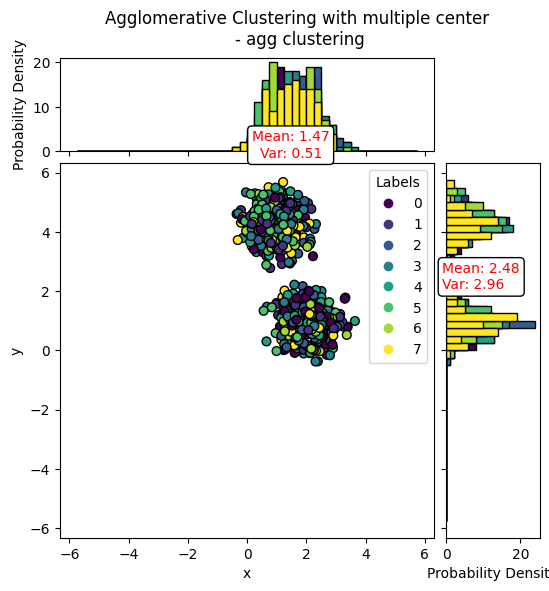

In [ ]:
#pred4 = agg_optimal_clustering_case1(multiple_data, multiple_labels, k, "Agglomerative Clustering with multiple center \n- agg clustering")
compare_clustering(multiple_data,k,"Agglomerative Clustering with multiple center \n- agg clustering")

UFOC

In [ ]:
comper_criteria(multiple_data, k,trace_criterion,"HFOC outcome for trace criteria")

In [ ]:

comper_criteria(multiple_data, k,determinant_criterion,"HFOC outcome for determination criteria")

In [ ]:

comper_criteria(multiple_data, k,invariant_criterion,"HFOC outcome for invariant criteria")

TypeError: comper_criteria() takes 3 positional arguments but 4 were given

<h2>2D data shaped like circles

mle estimation with random initialization

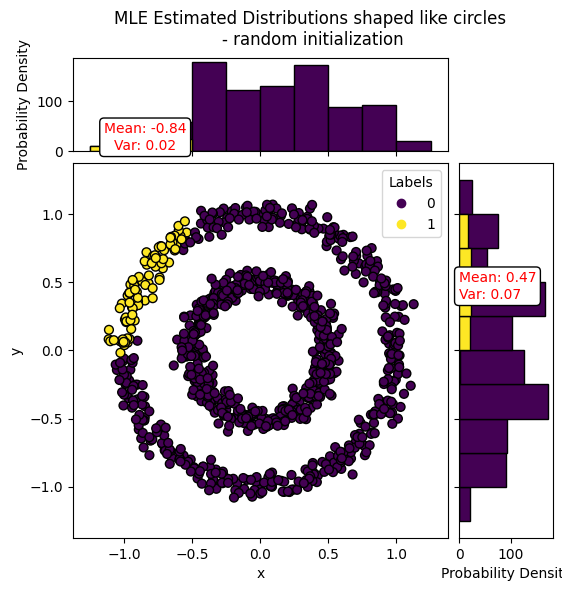

Accuracy: 0.00%


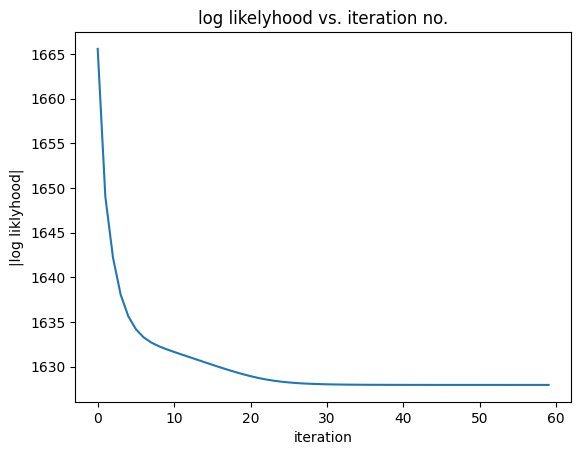

In [ ]:
k=2
d=2
circles_data, circles_labels = make_circles(n_samples=1000, factor=0.5, noise=0.05, random_state=0)
init1 = initial_model(circles_data,k, d, 'rand', phi=None, sigma=None)
phi1, mu1, sigma1, lol1, pred1 = MLE(circles_data,circles_labels, init1,'MLE Estimated Distributions shaped like circles \n- random initialization', case=1)
plot_log_likelihood(lol1)

mle estimation with KNN initialization

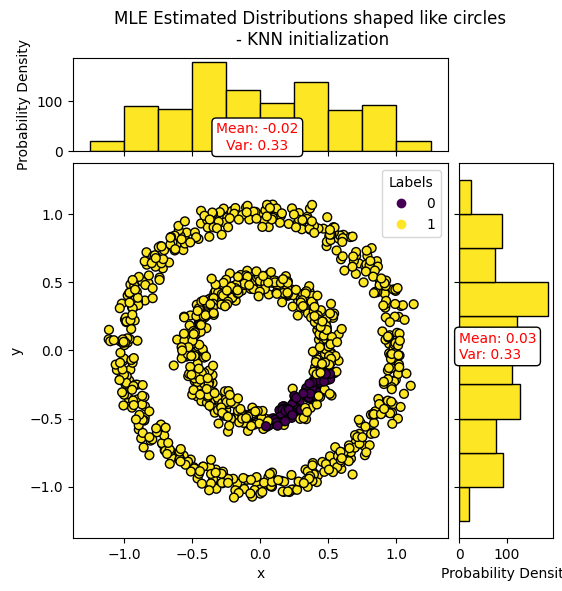

Accuracy: 0.00%


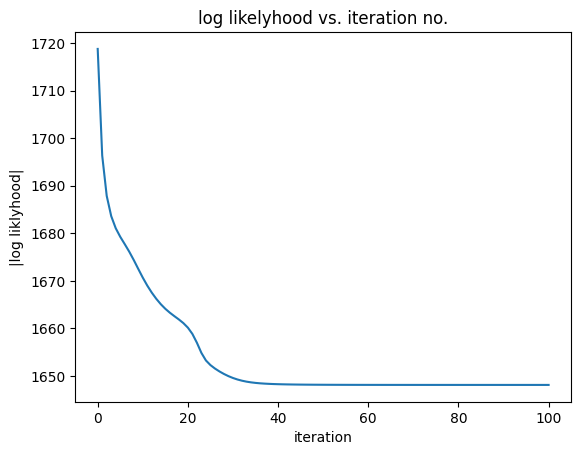

In [ ]:
init1 = initial_model(circles_data,k, d, 'knn', phi=None, sigma=None)
phi1, mu1, sigma1, lol1, pred1 = MLE(circles_data,circles_labels, init1,'MLE Estimated Distributions shaped like circles \n- KNN initialization', case=1)
plot_log_likelihood(lol1)

agg clustering

c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


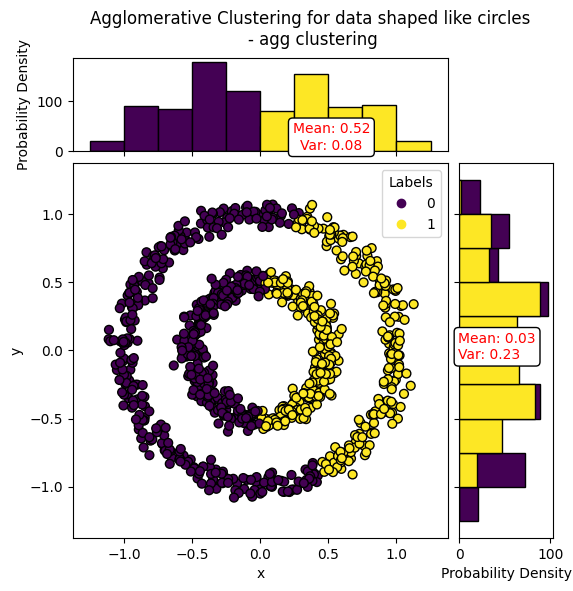

Accuracy: 55.10%


In [ ]:
#pred4 = agg_optimal_clustering_case1(circles_data, circles_labels, k, "Agglomerative Clustering for data shaped like circles \n- agg clustering")
compare_clustering(circles_data,k,"Agglomerative Clustering for data shaped like circles \n- ")

UFOC

In [ ]:
comper_criteria(circles_data, k,trace_criterion,"HFOC outcome for trace criteria")

In [ ]:

comper_criteria(circles_data, k,determinant_criterion,"HFOC outcome for determination criteria")

In [ ]:

comper_criteria(circles_data, k,invariant_criterion,"HFOC outcome for invariant criteria")

TypeError: comper_criteria() takes 3 positional arguments but 4 were given

<h2> 2D data shaped like moon

MLE estemation with random initialization

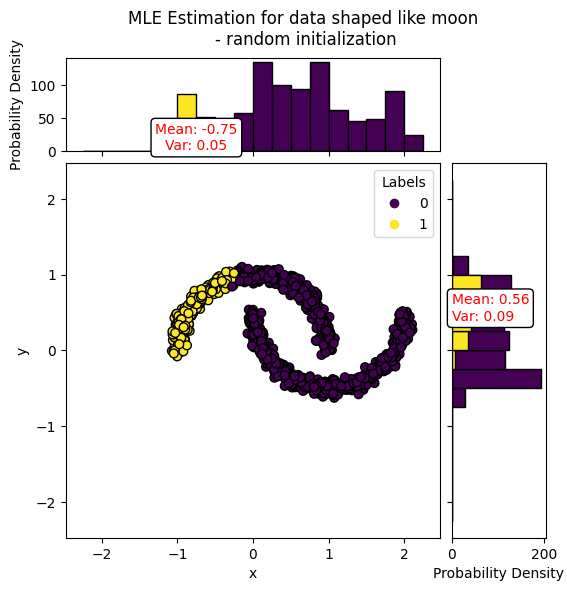

Accuracy: 55.10%


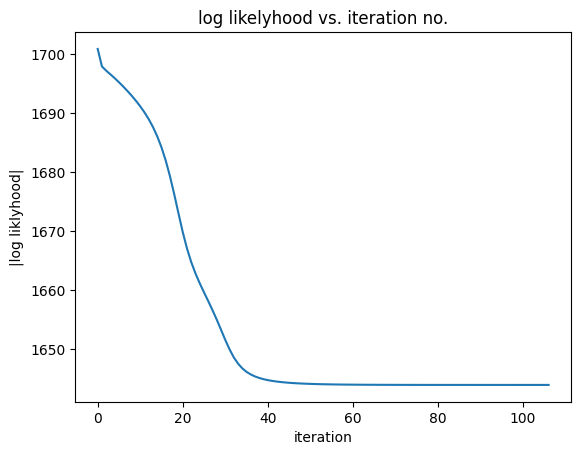

In [ ]:
k=2
d=2
moon_data, moon_labels = make_moons(n_samples=1000, noise=0.05)
init1 = initial_model(moon_data,k, d, 'rand', phi=None, sigma=None)
phi1, mu1, sigma1, lol1, pred1 = MLE(moon_data,moon_labels, init1,'MLE Estimation for data shaped like moon \n- random initialization', case=1)
plot_log_likelihood(lol1)

MLE estimation with KNN initialization

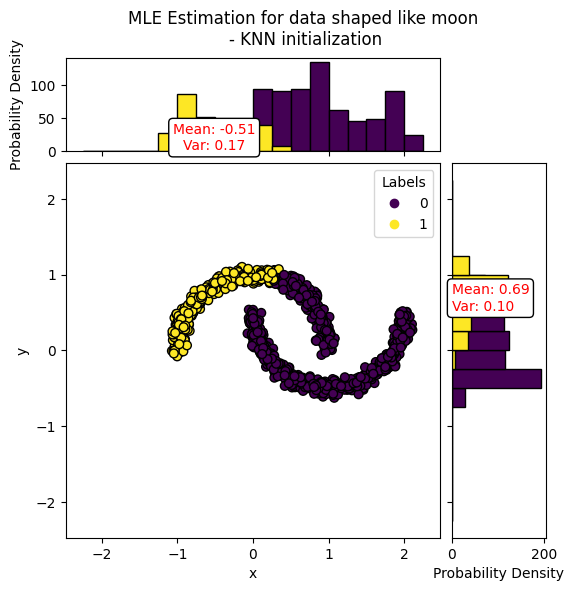

Accuracy: 55.10%


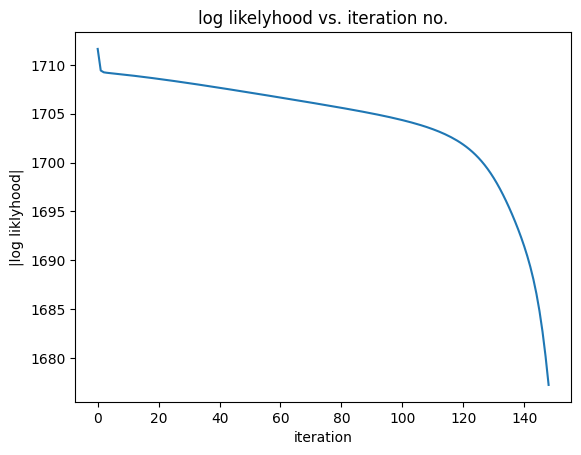

In [ ]:
init1 = initial_model(moon_data,k, d, 'knn', phi=None, sigma=None)
phi1, mu1, sigma1, lol1, pred1 = MLE(moon_data,multiple_labels, init1,'MLE Estimation for data shaped like moon \n- KNN initialization', case=1)
plot_log_likelihood(lol1)


agg clastering

c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


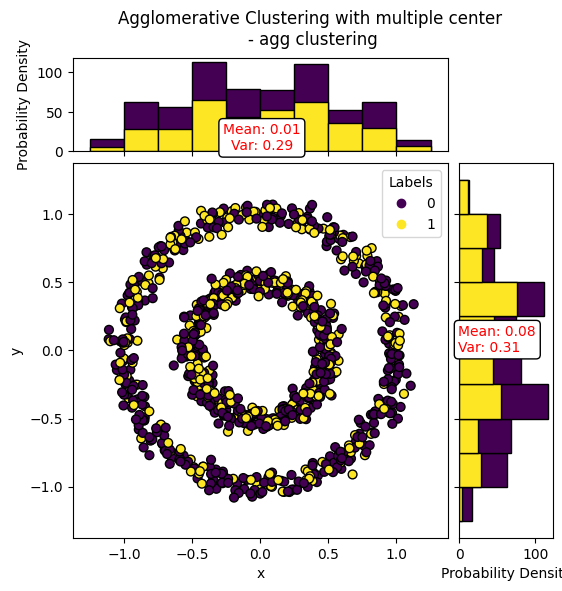

Accuracy: 14.50%


In [ ]:
#pred4= agg_optimal_clustering_case1(moon_data, moon_labels, k, "Agglomerative Clustering with multiple center \n- agg clustering")
compare_clustering(moon_data,k,"Agglomerative Clustering with multiple center \n- ")

UFOC

UFOC

In [ ]:
comper_criteria(circles_data, k,trace_criterion,"HFOC outcome for trace criteria")

In [ ]:

comper_criteria(circles_data, k,determinant_criterion,"HFOC outcome for determination criteria")

In [ ]:

comper_criteria(circles_data, k,invariant_criterion,"HFOC outcome for invariant criteria")

TypeError: comper_criteria() takes 3 positional arguments but 4 were given

<h2> uniformly spred data, shaped like a squre

mle estimation with random initialization

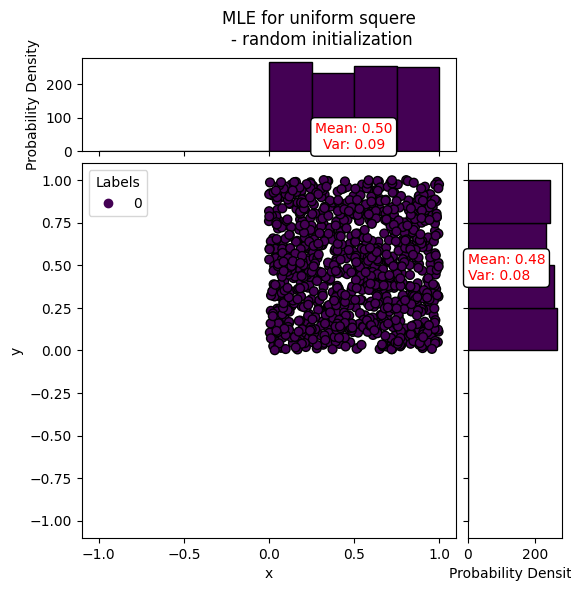

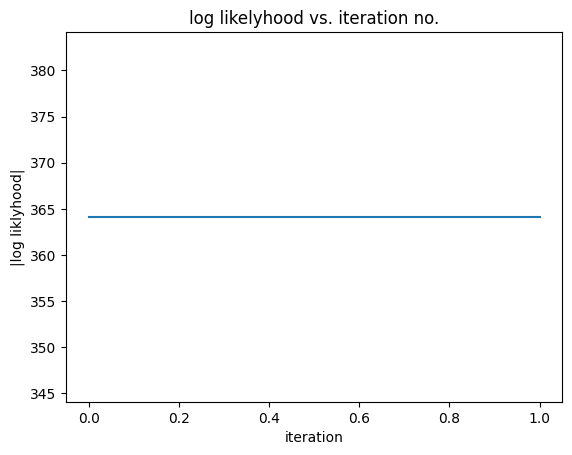

In [ ]:
k=1
d=2
square = np.random.rand(1000, 2)
init1 = initial_model(square,k, d, 'rand', phi=None, sigma=None)
phi1, mu1, sigma1, lol1, pred1 = MLE(square,0, init1,'MLE for uniform squere \n- random initialization', case=1)
plot_log_likelihood(lol1)

mle estimation with kmeans initialization

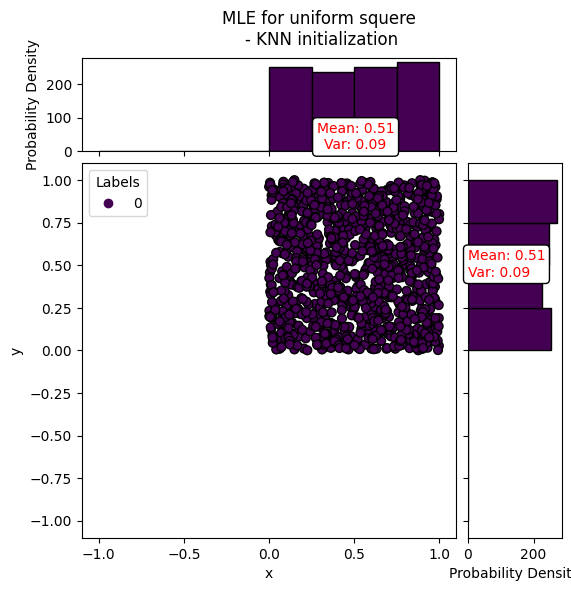

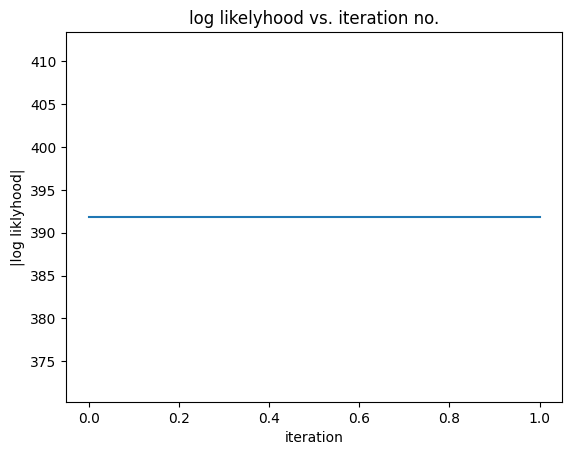

In [ ]:
init1 = initial_model(square,k, d, 'knn', phi=None, sigma=None)
phi1, mu1, sigma1, lol1, pred1 = MLE(square,0, init1,'MLE for uniform squere \n- KNN initialization', case=1)
plot_log_likelihood(lol1)

AGG clustering

c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


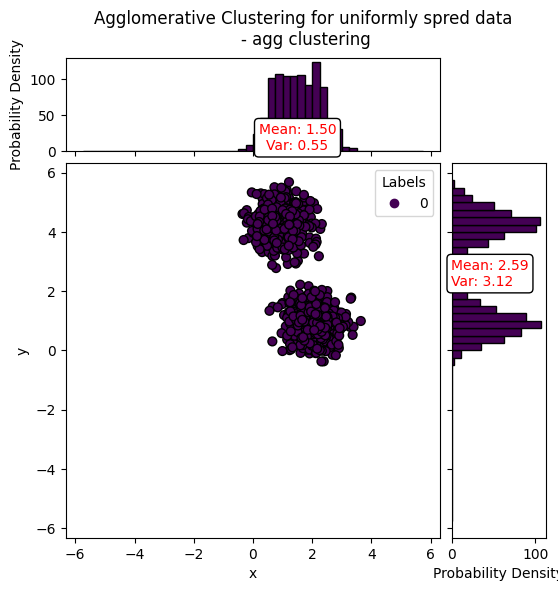

Accuracy: 0.00%


In [ ]:
pred, accuracy= agg_optimal_clustering_case1(square, 0, k, "Agglomerative Clustering for uniformly spred data \n- agg clustering")
print(f"Accuracy: {accuracy4:.2f}%")

UFOC- with trace

K = 1 : V = 173.45556524197409
K = 2 : V = 230.08842302746757
K = 3 : V = 203.3337770697837
K = 4 : V = 168.6088091950554


c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\User\AppData\Local\Temp\ipykernel_1204\3992755668.py:10: RuntimeWarning: Degrees of freedom <= 0 for slice
  S_i = np.cov(clusters[k].T)
c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


K = 5 : V = nan


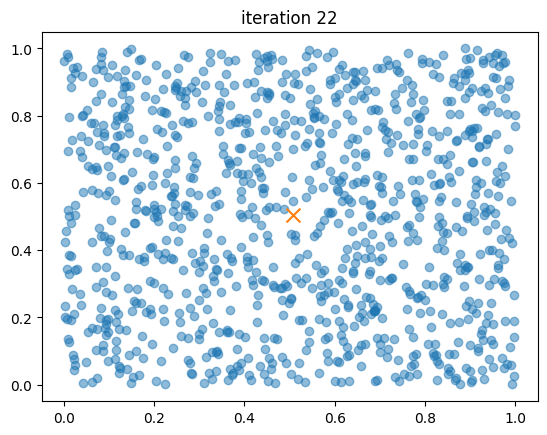

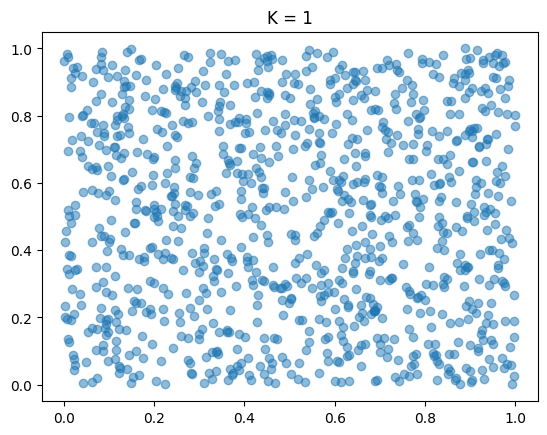

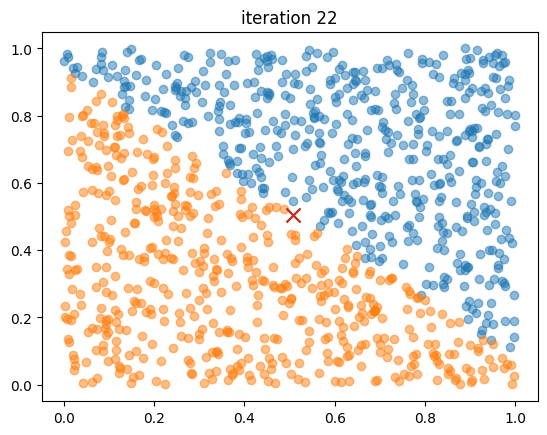

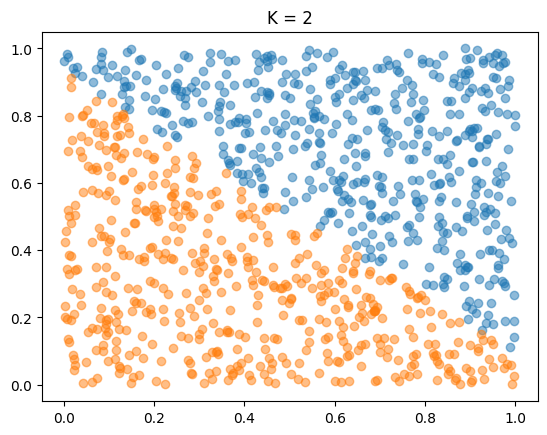

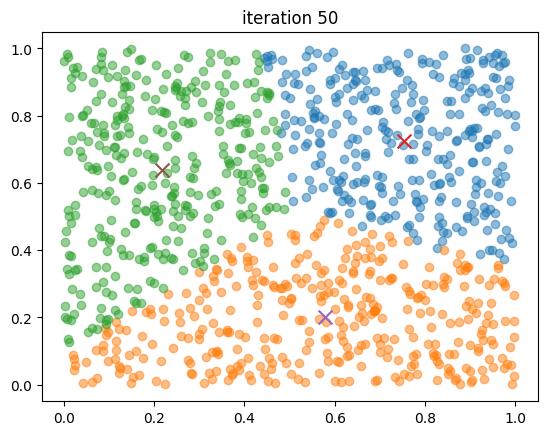

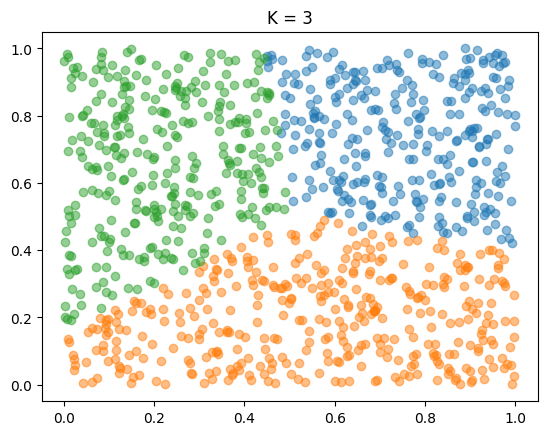

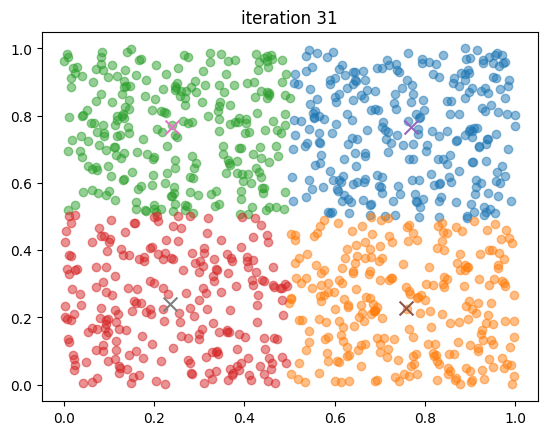

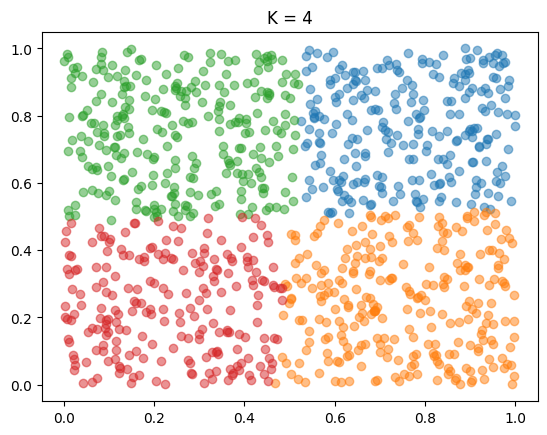

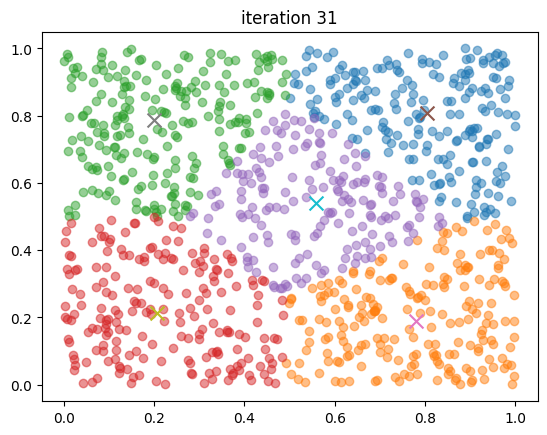

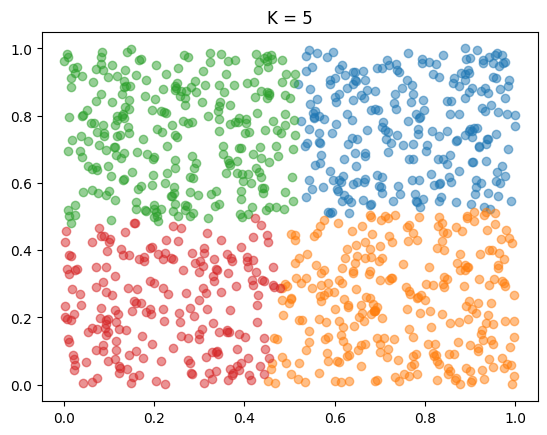

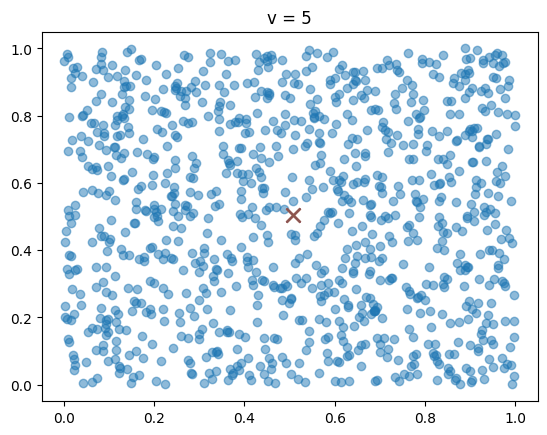

In [ ]:
V,C = WUOFC(square, 6, trace_criterion)
plot_clusters([square],title=f'v = {V+1}')
plot_centroids(C)

UFOC- with determinant criterion

K = 1 : V = 7.520882385229304e-06
K = 2 : V = 1.9537418817605806e-05
K = 3 : V = 2.1966385938907378e-05
K = 4 : V = 2.8287182177485945e-05


c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\User\AppData\Local\Temp\ipykernel_1204\2348484615.py:10: RuntimeWarning: Degrees of freedom <= 0 for slice
  S_i = np.cov(c.T)
c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  

ZeroDivisionError: division by zero

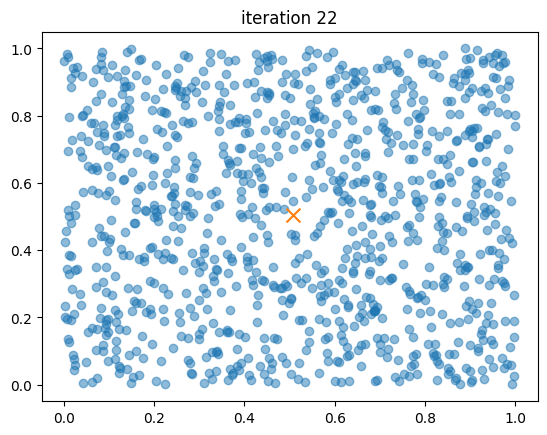

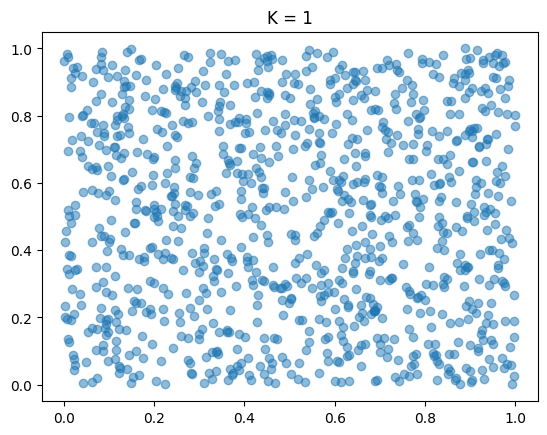

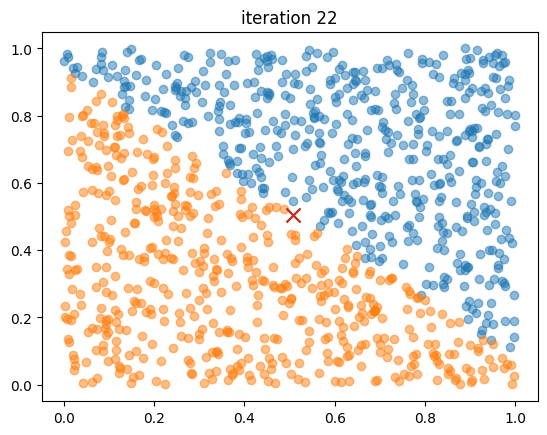

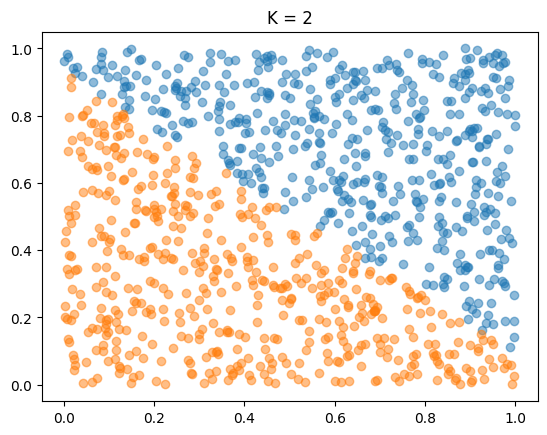

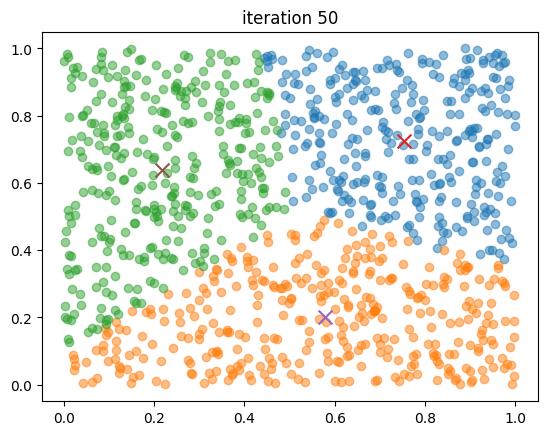

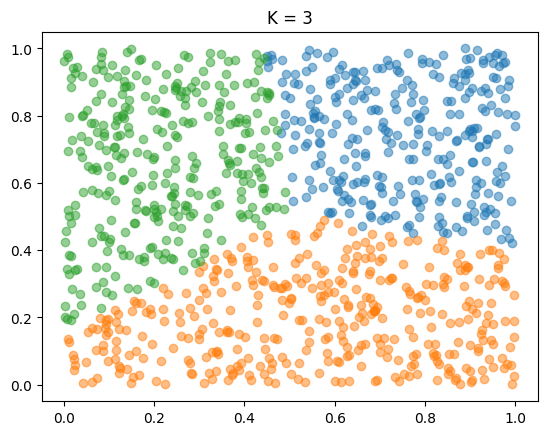

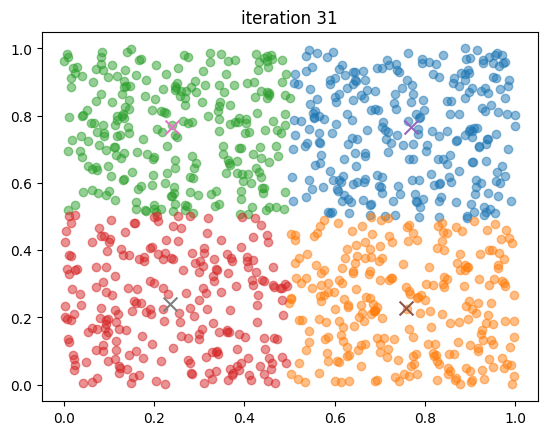

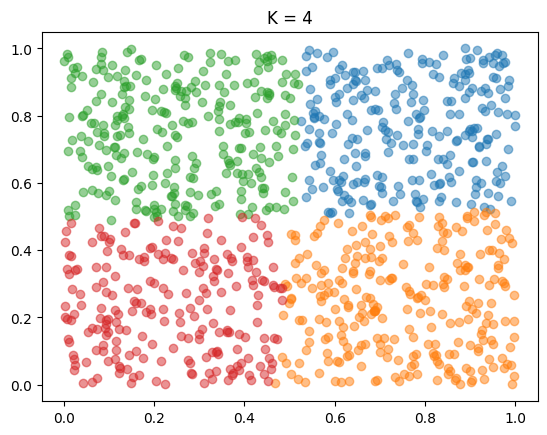

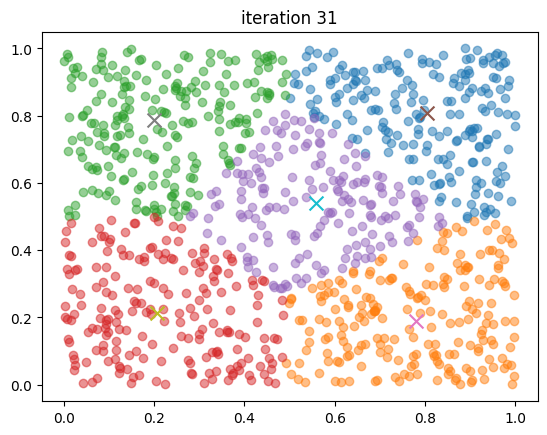

In [ ]:
V,C = WUOFC(square, 7, determinant_criterion)
plot_clusters([square],title=f'v = {V+1}')
plot_centroids(C)

UFOC with Invariant criterion

K = 1 : V = inf
K = 2 : V = 2.6834476272829866e-15
K = 3 : V = 3.5373669901584723e-10
K = 4 : V = 5.02418857887541e-09


C:\Users\User\AppData\Local\Temp\ipykernel_1204\1656842895.py:15: RuntimeWarning: Degrees of freedom <= 0 for slice
  S_w = np.sum([np.cov(c.T) for c in clusters],axis=0)


K = 5 : V = nan
K = 6 : V = nan


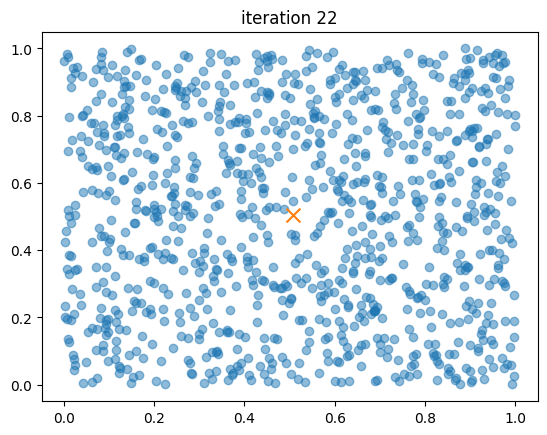

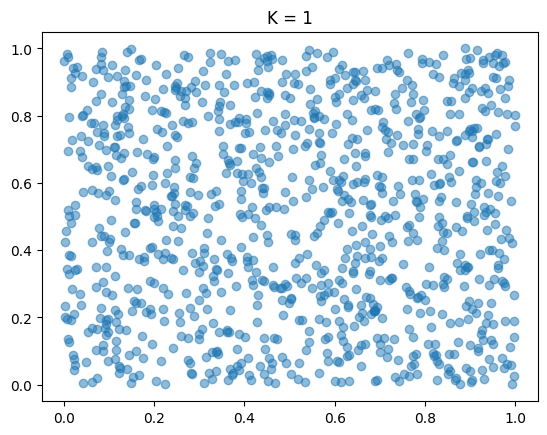

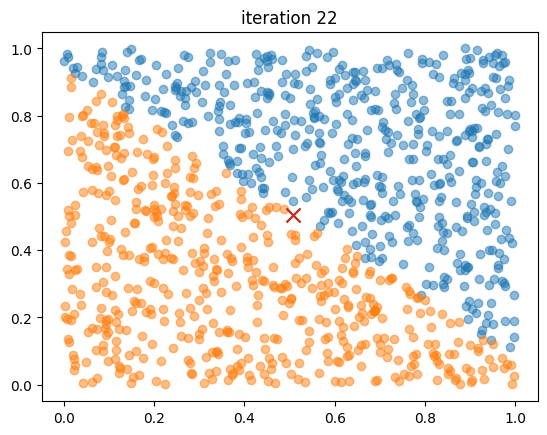

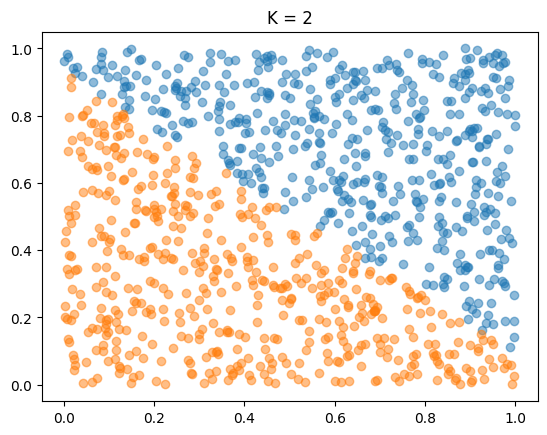

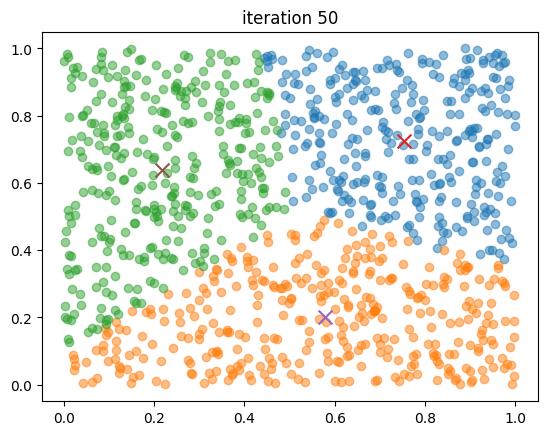

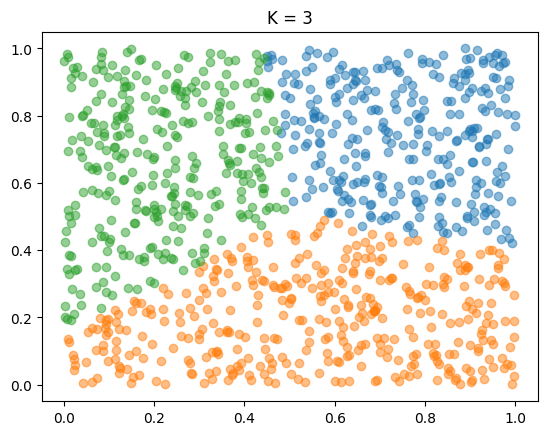

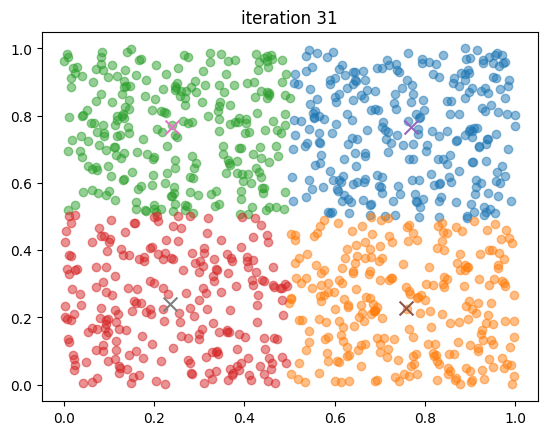

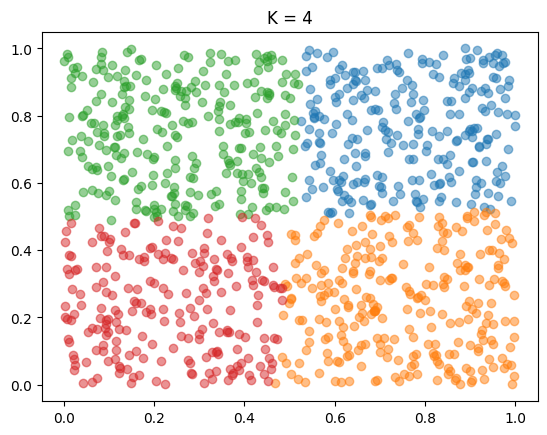

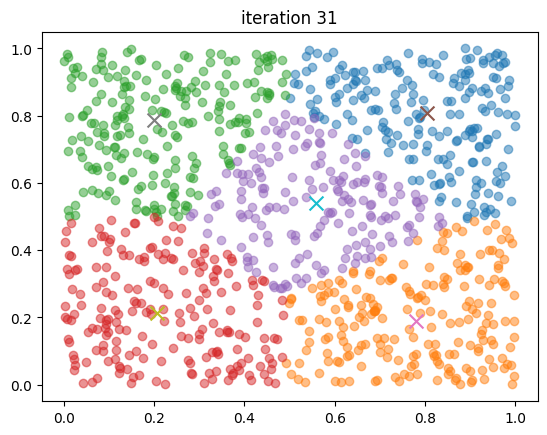

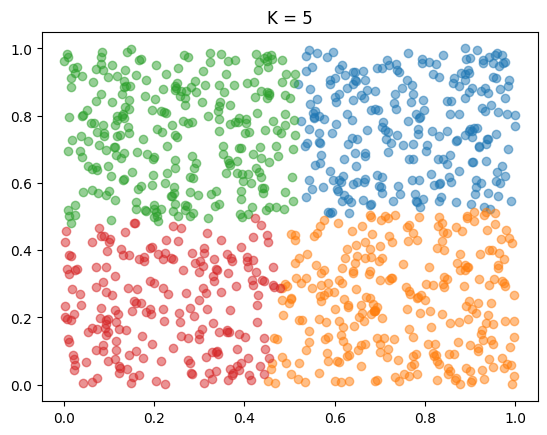

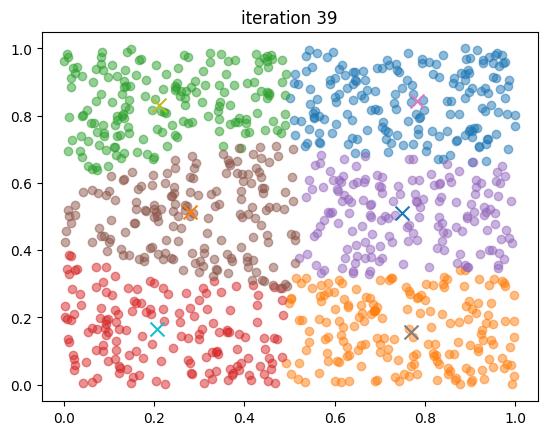

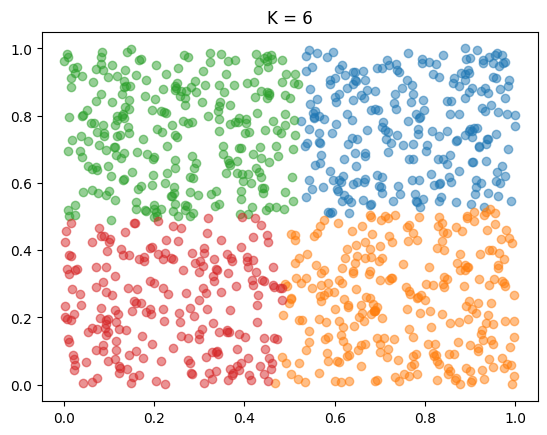

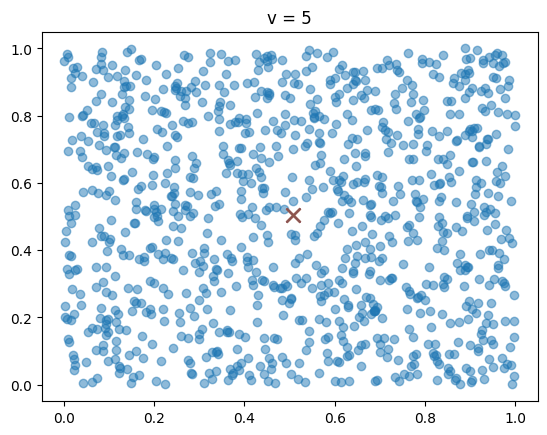

In [ ]:
V,C = WUOFC(square, 7, invariant_criterion)
plot_clusters([square],title=f'v = {V+1}')
plot_centroids(C)

agg clustering

<h2> uniformly spred data, shaped like parallelogram

mle estimation with random initialization

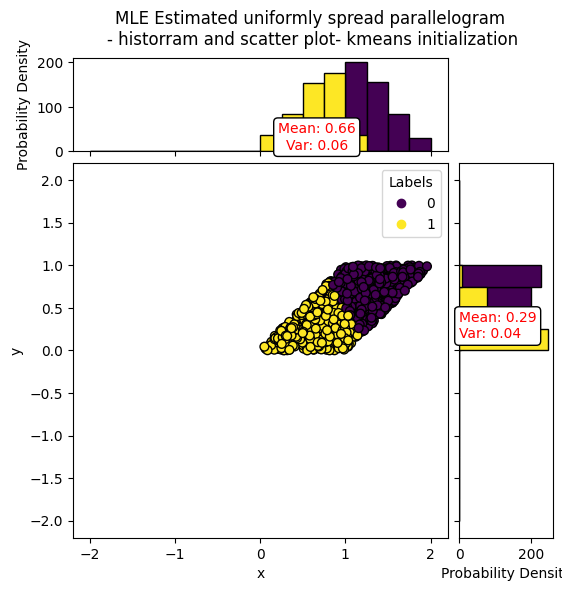

In [ ]:
parallelogram = np.random.rand(1000, 2)
parallelogram[:, 0] = parallelogram[:, 0] + parallelogram[:, 1]
pred1 =gauss_mle_cluster_case2( parallelogram, sigma, p, initial_type='rand')
scatter_plt( parallelogram, pred1, -1,
                                    'MLE Estimated uniformly spread parallelogram \n- historram and scatter plot- kmeans initialization')
    

mle estimation with kmeans initialization

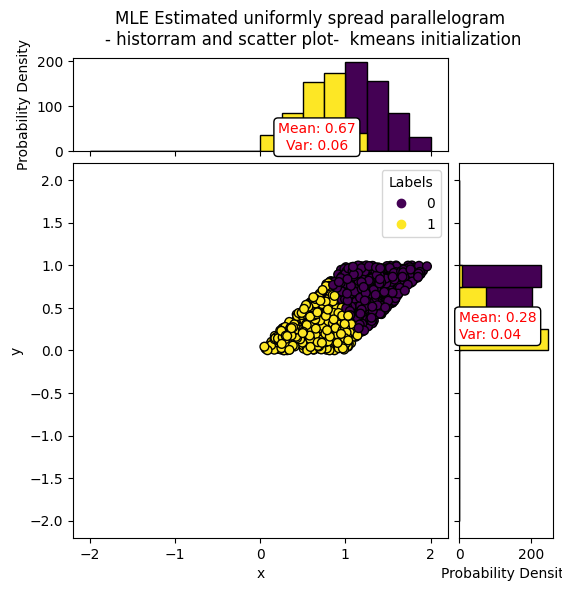

In [ ]:
pred2 =gauss_mle_cluster_case2( parallelogram, sigma, p, initial_type='kmeans')
scatter_plt( parallelogram, pred2, -1,
                                    'MLE Estimated uniformly spread parallelogram \n- historram and scatter plot-  kmeans initialization')
    

agg clustering

In [ ]:
pred3 =agg_clustering_case2( parallelogram, 2, 'min')
scatter_plt( parallelogram, pred3, -1,
                                    'agg Estimated uniformly spread parallelogram \n- historram and scatter plot-  distance type min')
    

c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


[1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1
 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1
 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1
 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1
 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0
 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0
 1 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1
 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1
 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0
 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0
 0 1 0 0 1 0 0 1 0 0 0 0 

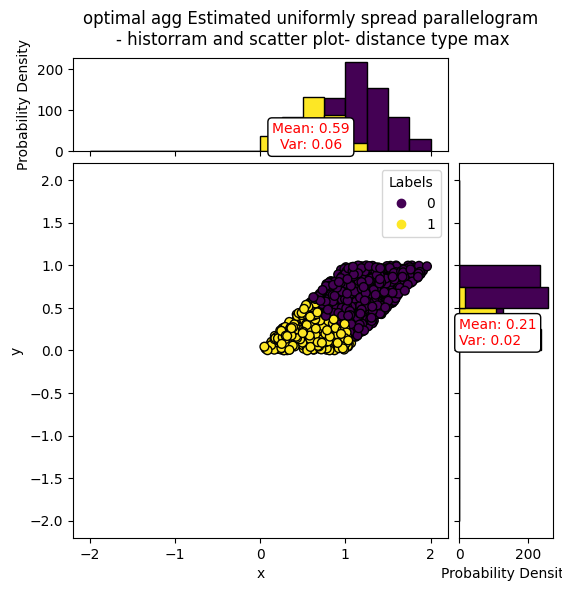

In [ ]:
pred4 =agg_optimal_clustering_case2( parallelogram, 2)
scatter_plt( parallelogram, pred4, -1,
                                    'optimal agg Estimated uniformly spread parallelogram \n- historram and scatter plot- distance type max')


<h2> uniformly spred data, shaped like triangle

mle estimation with random initialization

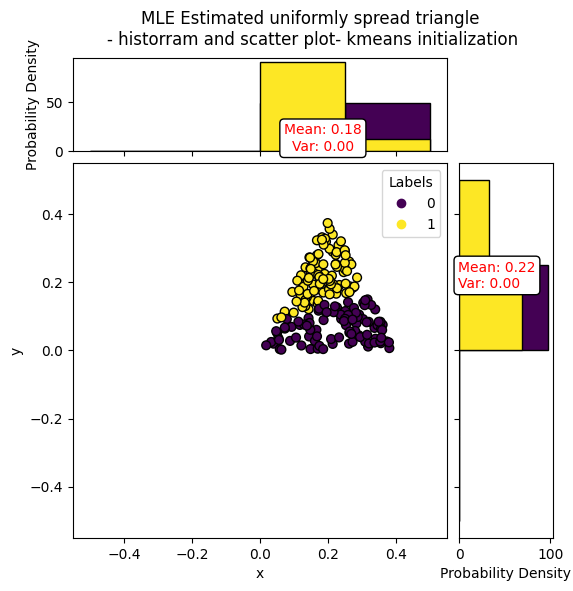

In [ ]:
v1 = np.array([0, 0])
v2 = np.array([0.2, 0.4])
v3 = np.array([0.4, 0])
u = np.random.uniform(size=(200, 1))
v = np.random.uniform(size=(200, 1))
triangle = (1 - np.sqrt(u)) * v1 + (np.sqrt(u) * (1 - v)) * v2 + (np.sqrt(u) * v) * v3
pred1 = gauss_mle_cluster_case2(triangle, sigma, p, initial_type='rand')
scatter_plt(triangle, pred1, -1,
                                    'MLE Estimated uniformly spread triangle \n- historram and scatter plot- kmeans initialization')
    

mle estimation with kmeans initialization

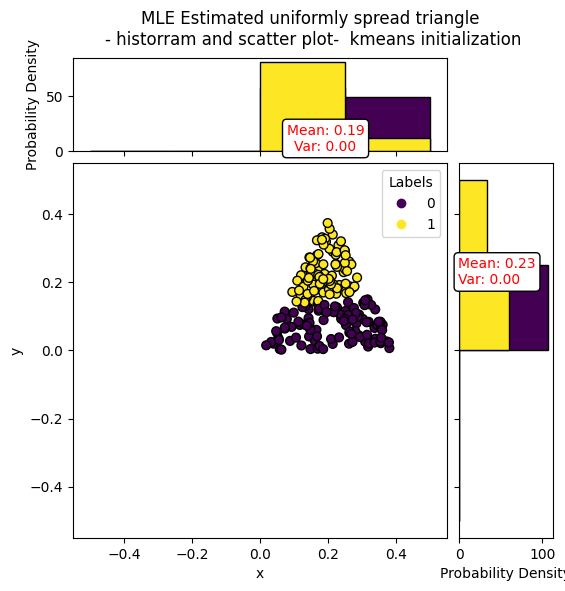

In [ ]:
pred2 =gauss_mle_cluster_case2(triangle, sigma, p, initial_type='kmeans')
scatter_plt(triangle, pred2, -1,
                                    'MLE Estimated uniformly spread triangle \n- historram and scatter plot-  kmeans initialization')
    

agg clustering

In [ ]:
pred3 =agg_clustering_case2(triangle, 2, 'min')
scatter_plt(triangle, pred3, -1,
                                    'agg Estimated uniformly spread triangle \n- historram and scatter plot-  distance type min')
   

TypeError: agg_clustering_case2() takes 1 positional argument but 3 were given

c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


[1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0 1
 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0
 0 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1
 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0
 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1
 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0]


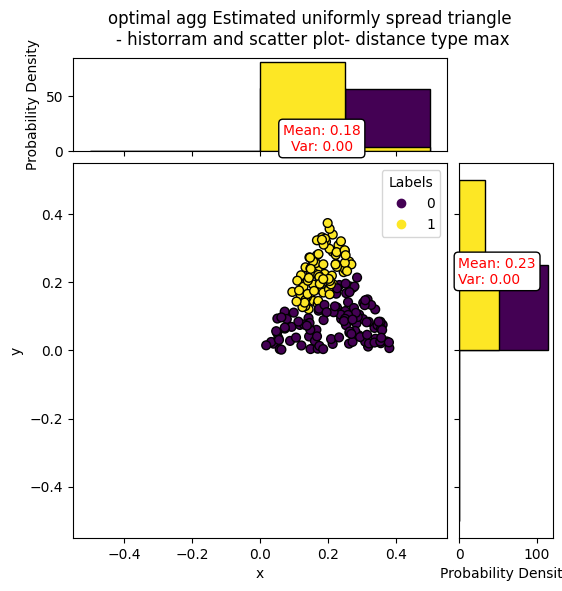

In [ ]:
pred4 = agg_optimal_clustering_case2(triangle, 2)
scatter_plt(triangle, pred4, -1,
                                    'optimal agg Estimated uniformly spread triangle \n- historram and scatter plot- distance type max')
